In [75]:
#pip install selenium
!pip install unidecode

  Using cached Unidecode-1.3.7-py3-none-any.whl (235 kB)


In [76]:
#import libraries
import requests
from bs4 import BeautifulSoup
import lxml
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import json
import numpy as np
from unidecode import unidecode

In [44]:
#Read Andrew's IMDB data
df = pd.read_csv('Prophet1.csv', index_col = 0)
df['Name'] = df_movie.index
df_movie = pd.read_csv('Prophet1.csv', index_col = 0)
df_movie['Name'] = df_movie.index
df_movie.head()

,IMDB Ratings,IMDB Score,Content Rating,Date Released,year,month,day of the week,Genres,Genre A,Genre B,...,Writer 3,Runtime,Nominations,Awards,Estimated Budget,Budget Currency,Gross Revenue US&Canada USD,Opening Weekend Revenue US&Canada USD,Gross Revenue Worldwide USD,Name
Name,,,,,,,,,,,,,,,,,,,,,
Avatar: The Way of Water,469417,7.6,PG,2022-12-16,2022,12,4,['Action' 'Adventure' 'Fantasy'],Action,Adventure,...,Amanda Silver,192,135,65,350000000,$,684075767,134100226,2320250281,Avatar: The Way of Water
Puss in Boots: The Last Wish,161291,7.8,PG,2022-12-21,2022,12,2,['Animation' 'Adventure' 'Comedy'],Animation,Adventure,...,Tom Wheeler,102,56,5,90000000,$,185535345,12429515,481080374,Puss in Boots: The Last Wish
Babylon,153248,7.1,18A,2022-12-23,2022,12,4,['Comedy' 'Drama' 'History'],Comedy,Drama,...,none,189,146,43,110000000,$,15351455,3603368,63351455,Babylon
A Man Called Otto,141943,7.5,G,2023-01-13,2023,1,4,['Comedy' 'Drama'],Comedy,Drama,...,David Magee,126,8,0,50000000,$,64267657,56257,113190218,A Man Called Otto
M3GAN,132495,6.4,14A,2023-01-06,2023,1,4,['Horror' 'Sci-Fi' 'Thriller'],Horror,Sci-Fi,...,none,102,2,1,12000000,$,95043350,30429860,179973454,M3GAN


In [117]:
for i, idx in enumerate(df_movie.index):
    name = str(df_movie.loc[idx]['Name'])  # Convert to string if not already a string
    pattern = re.compile(r'[^A-Za-z0-9 ]+', re.UNICODE)
    name = re.sub(pattern, '', unidecode(name)).replace(' ', '_').lower()
    typ = 'm'
    year = df_movie.loc[idx]['year']
    
    # Construct URLs
    URL = f'https://www.rottentomatoes.com/{typ}/{name}/'
    URL2 = f'https://www.rottentomatoes.com/{typ}/{name}_{year}/'
    
    print(f"Processing: {URL}")
    
    # Fetch content from URL
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    section = soup.find('script', {'id': 'scoreDetails'})

    #Append year for RT movies with duplicate names
    print(f"Processing: {URL2}")
    page2 = requests.get(URL2)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
    section2 = soup2.find('script', {'id': 'scoreDetails'})
    
    if section is None or (section2 is not None and len(section2.string) > len(section.string)):
        selected_section = section2
    else:
        selected_section = section
    
    if selected_section is None: # Error handling for titles that cannot be found
        print(f'Could not scrape data for this movie: {df_movie.loc[idx]["Name"]}')
        print(f'Progress: {round((i+1)/len(df_movie) * 100, 2)}%')
    
    else:

        script_content = selected_section.string

        if script_content:
            data = json.loads(script_content)

            audience_score = data['modal']['audienceScoreAll'].get('averageRating', 'N/A')
            audience_count = data['modal']['audienceScoreAll'].get('ratingCount', 'N/A')
            tomato_score = data['modal']['tomatometerScoreAll'].get('averageRating', 'N/A')
            tomato_count = data['modal']['tomatometerScoreAll'].get('ratingCount', 'N/A')

            df_movie.loc[idx, 'RT_audience_score'] = audience_score
            df_movie.loc[idx, 'RT_tomatometer_score'] = tomato_score
            df_movie.loc[idx, 'RT_audience_#reviews'] = audience_count
            df_movie.loc[idx, 'RT_tomatometer_#reviews'] = tomato_count

            print(df_movie.loc[idx, ['RT_audience_score', 'RT_tomatometer_score', 'RT_audience_#reviews','RT_tomatometer_#reviews']])
            print(f'Progress: {round((i+1)/len(df_movie) * 100, 2)}%')
        else:
            print('Script content is empty')

df_movie.to_csv('movie_data_with_rt.csv', index=False)  # Save the updated DataFrame to a CSV file

Processing: https://www.rottentomatoes.com/m/avatar_the_way_of_water/
Processing: https://www.rottentomatoes.com/m/avatar_the_way_of_water_2022/
RT_audience_score              4.3
RT_tomatometer_score          7.10
RT_audience_#reviews       48195.0
RT_tomatometer_#reviews      448.0
Name: Avatar: The Way of Water, dtype: object
Progress: 0.04%
Processing: https://www.rottentomatoes.com/m/puss_in_boots_the_last_wish/
Processing: https://www.rottentomatoes.com/m/puss_in_boots_the_last_wish_2022/
RT_audience_score              4.7
RT_tomatometer_score          7.60
RT_audience_#reviews       16575.0
RT_tomatometer_#reviews      192.0
Name: Puss in Boots: The Last Wish, dtype: object
Progress: 0.08%
Processing: https://www.rottentomatoes.com/m/babylon/
Processing: https://www.rottentomatoes.com/m/babylon_2022/
RT_audience_score             3.7
RT_tomatometer_score         6.40
RT_audience_#reviews       6999.0
RT_tomatometer_#reviews     358.0
Name: Babylon, dtype: object
Progress: 0.12%


In [121]:
len(df_movie[df_movie['RT_tomatometer_score'].isnull()])

362

In [122]:
362/2480

0.14596774193548387

In [52]:
df_movie.columns

Index(['IMDB Ratings', 'IMDB Score', 'Content Rating', 'Date Released', 'year',
       'month', 'day of the week', 'Genres', 'Genre A', 'Genre B', 'Genre C',
       'Keywords', 'Keyword 1', 'Keyword 2', 'Keyword 3', 'Stars', 'Star 1',
       'Star 2', 'Star 3', 'Directors', 'Director 1', 'Director 2',
       'Director 3', 'Writers', 'Writer 1', 'Writer 2', 'Writer 3', 'Runtime',
       'Nominations', 'Awards', 'Estimated Budget', 'Budget Currency',
       'Gross Revenue US&Canada USD', 'Opening Weekend Revenue US&Canada USD',
       'Gross Revenue Worldwide USD', 'Name',
       'rottentomatoes_tomatometer_score', 'rottentomatoes_audience_#reviews',
       'rottentomatoes_tomatometer_#reviews', 'RT_audience_score',
       'RT_tomatometer_score', 'RT_audience_#reviews',
       'RT_tomatometer_#reviews'],
      dtype='object')

In [85]:
#Start Here if csv export is complete

df_movie = pd.read_csv('movie_data_with_rt3.csv')
df_movie.index = df_movie['Name']

#Convert audience score from 5 star scale to out of 10 score
#df_movie['RT_audience_score'] = df_movie['RT_audience_score']*2

#Remove rows where RT_audience score is missing by first changing N/A to null
df_movie['RT_audience_score'].replace('N/A', np.nan, inplace=True)

# Drop rows where 'RT_audience_score' is null
df_movie.dropna(subset=['RT_audience_score'], inplace=True)

In [86]:
### Finding producers

In [113]:
for i, idx in enumerate(df_movie.index):
    name = str(df_movie.loc[idx]['Name'])  # Convert to string if not already a string
    pattern = re.compile(r'[^A-Za-z0-9 ]+', re.UNICODE)
    name = re.sub(pattern, '', unidecode(name)).replace(' ', '_').lower()
    typ = 'm'
    year = df_movie.loc[idx]['year']
    
    # Construct URLs
    URL = f'https://www.rottentomatoes.com/{typ}/{name}/'
    URL2 = f'https://www.rottentomatoes.com/{typ}/{name}_{year}/'
    
    print(f"Processing: {URL}")
    
    # Fetch content from URL
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    section = soup.find('script', {'id': 'scoreDetails'})

    # Append year for RT movies with duplicate names
    print(f"Processing: {URL2}")
    page2 = requests.get(URL2)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
    section2 = soup2.find('script', {'id': 'scoreDetails'})
    
    selected_soup = soup2 if section2 else soup  # Select soup2 if it exists, otherwise use soup

    # Find all 'li' tags with class 'info-item'
    info_items = selected_soup.find_all('li', class_='info-item')

    production_companies = []

    for item in info_items:
        label = item.find('b', class_='info-item-label')
        if label and label.text.strip() == 'Producer:':
            value_span = item.find('span', {'data-qa': 'movie-info-item-value'})
            if value_span:
                production_companies = value_span.get_text(strip=True).split(',')

                # Update specific row in DataFrame
                df_movie.at[idx, 'Producer'] = value_span.get_text(strip=True)

                print(df_movie.loc[idx, ['Producer']])
                print(f'Progress: {round((i+1)/len(df_movie) * 100, 2)}%')
            else:
                print('Script content is empty')

# Save the updated DataFrame to a CSV file
df_movie.to_csv('producers.csv', index=False)

Processing: https://www.rottentomatoes.com/m/avatar_the_way_of_water/
Processing: https://www.rottentomatoes.com/m/avatar_the_way_of_water_2022/
Producer    James Cameron,Jon Landau
Name: Avatar: The Way of Water, dtype: object
Progress: 0.05%
Processing: https://www.rottentomatoes.com/m/puss_in_boots_the_last_wish/
Processing: https://www.rottentomatoes.com/m/puss_in_boots_the_last_wish_2022/
Producer    Mark Swift
Name: Puss in Boots: The Last Wish, dtype: object
Progress: 0.1%
Processing: https://www.rottentomatoes.com/m/babylon/
Processing: https://www.rottentomatoes.com/m/babylon_2022/
Producer    Marc Platt,Matthew Plouffe,Olivia Hamilton
Name: Babylon, dtype: object
Progress: 0.15%
Processing: https://www.rottentomatoes.com/m/a_man_called_otto/
Processing: https://www.rottentomatoes.com/m/a_man_called_otto_2023/
Producer    Fredrik Wikström,Rita Wilson,Tom Hanks,Gary Go...
Name: A Man Called Otto, dtype: object
Progress: 0.2%
Processing: https://www.rottentomatoes.com/m/m3gan/
P

## Exploratory Data Analysis

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
#df_movie.drop('Prod1', axis=1, inplace=True)
#df_movie.drop('Prod2', axis=1, inplace=True)
#df_movie.drop('Prod3', axis=1, inplace=True)

producers.index = producers['Name']
df_movie['Producer'] = producers['Producer']
df_movie.to_csv('producers_clean.csv', index=False)

In [134]:
#producers = pd.read_csv('producers.csv')
#producers
df_movie

,IMDB Ratings,IMDB Score,Content Rating,Date Released,year,month,day of the week,Genres,Genre A,Genre B,...,Budget Currency,Gross Revenue US&Canada USD,Opening Weekend Revenue US&Canada USD,Gross Revenue Worldwide USD,Name,RT_audience_score,RT_tomatometer_score,RT_audience_#reviews,RT_tomatometer_#reviews,Producer
Name,,,,,,,,,,,,,,,,,,,,,
Avatar: The Way of Water,469417,7.6,PG,2022-12-16,2022,12,4,['Action' 'Adventure' 'Fantasy'],Action,Adventure,...,$,684075767,134100226,2320250281,Avatar: The Way of Water,8.6,7.1,48195.0,448.0,"James Cameron,Jon Landau"
Puss in Boots: The Last Wish,161291,7.8,PG,2022-12-21,2022,12,2,['Animation' 'Adventure' 'Comedy'],Animation,Adventure,...,$,185535345,12429515,481080374,Puss in Boots: The Last Wish,9.4,7.6,16575.0,192.0,Mark Swift
Babylon,153248,7.1,18A,2022-12-23,2022,12,4,['Comedy' 'Drama' 'History'],Comedy,Drama,...,$,15351455,3603368,63351455,Babylon,7.4,6.4,6999.0,358.0,"Marc Platt,Matthew Plouffe,Olivia Hamilton"
A Man Called Otto,141943,7.5,G,2023-01-13,2023,1,4,['Comedy' 'Drama'],Comedy,Drama,...,$,64267657,56257,113190218,A Man Called Otto,9.0,6.1,10436.0,207.0,"Fredrik Wikström,Rita Wilson,Tom Hanks,Gary Go..."
M3GAN,132495,6.4,14A,2023-01-06,2023,1,4,['Horror' 'Sci-Fi' 'Thriller'],Horror,Sci-Fi,...,$,95043350,30429860,179973454,M3GAN,7.6,7.2,11348.0,315.0,"Jason Blum,James Wan,Couper Samuelson"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mean Streets,116925,7.2,18+,1974-03-08,1974,3,4,['Crime' 'Drama' 'Thriller'],Crime,Drama,...,$,32645,32645,59034,Mean Streets,8.0,8.8,55003.0,75.0,Jonathan T. Taplin
American Graffiti,96624,7.4,PG,1973-08-11,1973,8,5,['Comedy' 'Drama'],Comedy,Drama,...,unknown,unknown,unknown,unknown,American Graffiti,8.0,8.6,64846.0,62.0,"Francis Ford Coppola,Gary Kurtz"
Live and Let Die,113572,6.7,14+,1973-06-27,1973,6,2,['Action' 'Adventure' 'Thriller'],Action,Adventure,...,unknown,unknown,unknown,unknown,Live and Let Die,7.2,5.8,65030.0,53.0,"Albert R. Broccoli,Harry Saltzman"


In [135]:
# Count missing values in each column
missing_values = df_movie.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

IMDB Ratings                              0
IMDB Score                                0
Content Rating                            0
Date Released                             0
year                                      0
month                                     0
day of the week                           0
Genres                                    0
Genre A                                   0
Genre B                                   0
Genre C                                   0
Keywords                                  0
Keyword 1                                 0
Keyword 2                                 0
Keyword 3                                 0
Stars                                     0
Star 1                                    0
Star 2                                    0
Star 3                                    0
Directors                                 0
Director 1                                0
Director 2                                0
Director 3                      

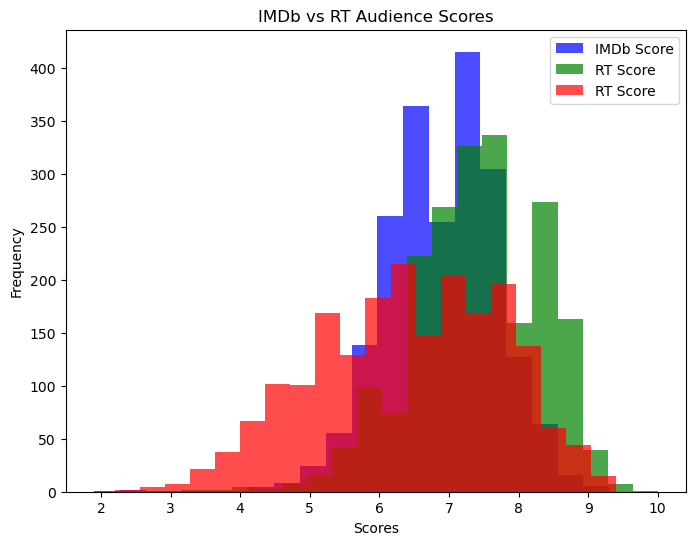

In [138]:
# Assuming df contains IMDb and RT scores in columns 'IMDB Score' and 'RT_audience_score'
plt.figure(figsize=(8, 6))

# Plot IMDb scores
plt.hist(df_movie['IMDB Score'], bins=20, alpha=0.7, label='IMDb Score', color='blue')

# Plot RT scores
plt.hist(df_movie['RT_audience_score'], bins=20, alpha=0.7, label='RT Score', color='green')

# Plot RT scores
plt.hist(df_movie['RT_tomatometer_score'], bins=20, alpha=0.7, label='RT Score', color='red')

plt.title('IMDb vs RT Audience Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [137]:
unique_producers = df_movie['Producer'].nunique()
unique_producers

1762

In [153]:
df_movie['Prod1'] = df_movie['Producer'].str.split(',').str[0]
df_movie['Prod2'] = df_movie['Producer'].str.split(',').str[1]
df_movie['Prod3'] = df_movie['Producer'].str.split(',').str[2]
df_movie['Prod4'] = df_movie['Producer'].str.split(',').str[3]
df_movie['Prod5'] = df_movie['Producer'].str.split(',').str[4]
df_movie['Prod6'] = df_movie['Producer'].str.split(',').str[5]

In [148]:
df_movie['Prod1'].value_counts()

Jerry Bruckheimer           23
Kevin Feige                 22
Joel Silver                 22
Neal H. Moritz              19
Jason Blum                  19
                            ..
Johnny Depp                  1
David Parfitt                1
Nicolas Duval-Adassovsky     1
Lars-Owe Carlberg            1
John Boorman                 1
Name: Prod1, Length: 993, dtype: int64

In [149]:
df_movie['Prod2'].value_counts()

Eric Fellner            17
Jack Giarraputo         11
Wyck Godfrey             9
Janet Healy              8
Roger Birnbaum           7
                        ..
Andrew Lauren            1
Tom Rice                 1
Arturo Paglia            1
Joshua Michael Stern     1
Harry Saltzman           1
Name: Prod2, Length: 1004, dtype: int64

In [150]:
df_movie['Prod3'].value_counts()

Eric Fellner           7
Fran Walsh             6
Clayton Townsend       6
Megan Ellison          6
Stacey Sher            5
                      ..
Phil Hay               1
Michael Tadross        1
Christopher Jenkins    1
Susan Cartsonis        1
Barry Spikings         1
Name: Prod3, Length: 761, dtype: int64

In [151]:
df_movie['Prod4'].value_counts()

Ian Bryce            5
Mark Gill            4
Richard S. Wright    4
Peter Jackson        3
Patrick McCormick    3
                    ..
Barbara De Fina      1
Lionel Wigram        1
Samuel Hadida        1
Peter Loehr          1
Alison O'Brien       1
Name: Prod4, Length: 440, dtype: int64

In [154]:
df_movie['Prod5'].value_counts()

Brian Oliver              4
Sebastien K. Lemercier    2
Mark Wahlberg             2
Don Granger               2
Ron Howard                2
                         ..
Jim Burke                 1
Walter Hill               1
Ivan Reitman              1
Terry Dougas              1
Edward Zwick              1
Name: Prod5, Length: 214, dtype: int64

In [155]:
df_movie['Prod6'].value_counts()

Akiva Goldsman    2
Bradley Thomas    2
Irwin Winkler     2
Tyler Thompson    2
Steve Tisch       2
                 ..
Will Ferrell      1
James Weaver      1
Danny Boyle       1
Yariv Lerner      1
Suzanne Todd      1
Name: Prod6, Length: 86, dtype: int64

In [157]:
# Concatenate all producer columns into a single Series
all_producers = pd.concat([df_movie['Prod1'], df_movie['Prod2'], df_movie['Prod3'],
                           df_movie['Prod4'], df_movie['Prod5'], df_movie['Prod6']])

# Count the occurrences of unique producer names
unique_producer_counts = all_producers.value_counts()

print(unique_producer_counts)


Joel Silver          30
Eric Fellner         28
Tim Bevan            27
Jerry Bruckheimer    26
Jason Blum           26
                     ..
Ilya Naishuller       1
Jack Heller           1
Ken Mok               1
Lawrence Inglee       1
Neal Miller           1
Length: 2293, dtype: int64


(array([1.324e+03, 3.980e+02, 1.740e+02, 1.020e+02, 7.400e+01, 5.300e+01,
        3.900e+01, 3.000e+01, 2.600e+01, 1.400e+01, 1.300e+01, 1.600e+01,
        4.000e+00, 2.000e+00, 5.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.        ,  1.96666667,  2.93333333,  3.9       ,  4.86666667,
         5.83333333,  6.8       ,  7.76666667,  8.73333333,  9.7       ,
        10.66666667, 11.63333333, 12.6       , 13.56666667, 14.53333333,
        15.5       , 16.46666667, 17.43333333, 18.4       , 19.36666667,
        20.33333333, 21.3       , 22.26666667, 23.23333333, 24.2       ,
        25.16666667, 26.13333333, 27.1       , 28.06666667, 29.03333333,
        30.        ]),
 <BarContainer object of 30 artists>)

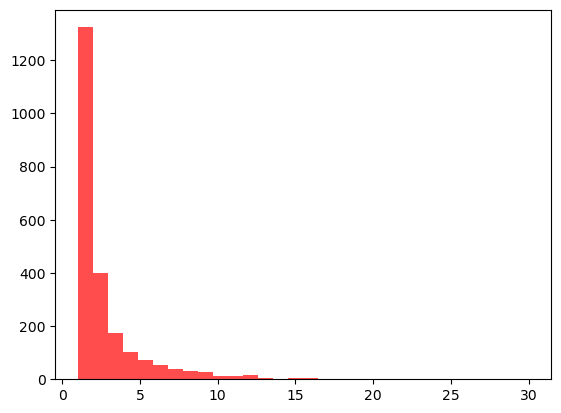

In [184]:
# Concatenate all producer columns into a single Series
all_producers = pd.concat([df_movie['Prod1'], df_movie['Prod2'], df_movie['Prod3'],
                           df_movie['Prod4'], df_movie['Prod5'], df_movie['Prod6']])

# Count the occurrences of unique producer names
unique_producer_counts = all_producers.value_counts()

plt.hist(unique_producer_counts, bins=30, alpha=0.7, label='RT Score', color='red')

(array([53., 39., 30., 26., 14., 13., 16.,  4.,  2.,  5.,  3.,  2.,  0.,
         1.,  1.,  1.,  1.,  2.,  0.,  2.,  1.,  2.,  1.,  1.,  0.,  1.]),
 array([ 6.        ,  6.92307692,  7.84615385,  8.76923077,  9.69230769,
        10.61538462, 11.53846154, 12.46153846, 13.38461538, 14.30769231,
        15.23076923, 16.15384615, 17.07692308, 18.        , 18.92307692,
        19.84615385, 20.76923077, 21.69230769, 22.61538462, 23.53846154,
        24.46153846, 25.38461538, 26.30769231, 27.23076923, 28.15384615,
        29.07692308, 30.        ]),
 <BarContainer object of 26 artists>)

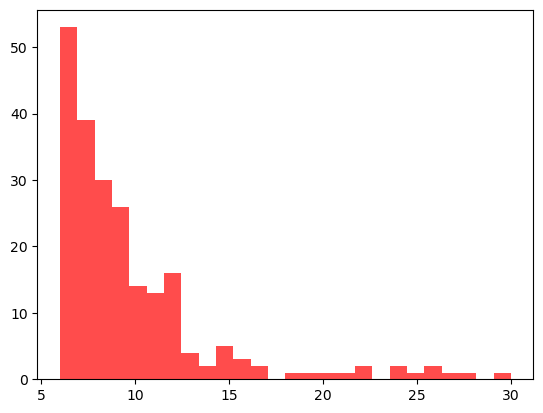

In [186]:
plt.hist(unique_producer_counts[unique_producer_counts>5], bins=26, alpha=0.7, label='RT Score', color='red')

In [188]:
#Filter our producers with 5 or less movies to reduce size of dataset
cleaned_producers = unique_producer_counts[unique_producer_counts>5]
cleaned_producers

Joel Silver           30
Eric Fellner          28
Tim Bevan             27
Jerry Bruckheimer     26
Jason Blum            26
                      ..
Laurence Mark          6
Hiram Garcia           6
Guillermo del Toro     6
Kevin Misher           6
JoAnne Sellar          6
Length: 221, dtype: int64

In [233]:
# Assuming 'all_producers' is your Series
df_movie['Dom_Profit'] = df_movie['Gross Revenue US&Canada USD'] - df_movie['Estimated Budget']
df_movie['Dom_ROI'] = df_movie['Dom_Profit'] / df_movie['Estimated Budget']

producers_df = cleaned_producers.to_frame(name='Movie Count')

# Convert producer names in producers_df index to a list
producer_names = producers_df.index.tolist()

# Check if producer names from producers_df index appear in df_movie['Producer']
for producer in producer_names:
    # Check if the producer name appears in any 'Producer' entry in df_movie
    mask = df_movie['Producer'].str.contains(producer, na=False)
    
    #PROFIT
    producers_df.loc[producer, 'Tot_Profit'] = df_movie.loc[mask, 'Dom_Profit'].sum()
    producers_df.loc[producer, 'Avg_Profit'] = df_movie.loc[mask, 'Dom_Profit'].mean()
    producers_df.loc[producer, 'Max_Profit'] = df_movie.loc[mask, 'Dom_Profit'].max()
    producers_df.loc[producer, 'Min_Profit'] = df_movie.loc[mask, 'Dom_Profit'].min()
    
    #REVENUE
    producers_df.loc[producer, 'Tot_Rev'] = df_movie.loc[mask, 'Gross Revenue US&Canada USD'].sum()
    producers_df.loc[producer, 'Avg_Rev'] = df_movie.loc[mask, 'Gross Revenue US&Canada USD'].mean()
    producers_df.loc[producer, 'Max_Rev'] = df_movie.loc[mask, 'Gross Revenue US&Canada USD'].max()
    producers_df.loc[producer, 'Min_Rev'] = df_movie.loc[mask, 'Gross Revenue US&Canada USD'].min()
    
    #BUDGET
    producers_df.loc[producer, 'Tot_Bugd'] = df_movie.loc[mask, 'Estimated Budget'].sum()
    producers_df.loc[producer, 'Avg_Budg'] = df_movie.loc[mask, 'Estimated Budget'].mean()
    producers_df.loc[producer, 'Max_Budg'] = df_movie.loc[mask, 'Estimated Budget'].max()
    producers_df.loc[producer, 'Min_Budg'] = df_movie.loc[mask, 'Estimated Budget'].min()
    
    #ROI
    producers_df.loc[producer, 'Avg_ROI'] = df_movie.loc[mask, 'Dom_ROI'].mean()
    producers_df.loc[producer, 'Max_ROI'] = df_movie.loc[mask, 'Dom_ROI'].max()
    producers_df.loc[producer, 'Min_ROI'] = df_movie.loc[mask, 'Dom_ROI'].min()
    
    #Ratings
    producers_df.loc[producer, 'Avg_RT_Ascore'] = df_movie.loc[mask, 'RT_audience_score'].mean()
    producers_df.loc[producer, 'Max_RT_Ascore'] = df_movie.loc[mask, 'RT_audience_score'].max()
    producers_df.loc[producer, 'Min_RT_Ascore'] = df_movie.loc[mask, 'RT_audience_score'].min()

# Replace NaN values with 'N/A' in the DataFrame
producers_df = producers_df.fillna('N/A')

print(producers_df)

                    Movie Count    Tot_Profit    Avg_Profit   Max_Profit  \
Joel Silver                  30  8.645467e+08  2.881822e+07  131576461.0   
Eric Fellner                 28  2.394043e+08  8.550153e+06   87809770.0   
Tim Bevan                    27  2.504567e+08  9.276173e+06   87809770.0   
Jerry Bruckheimer            26  1.604152e+09  6.416607e+07  548732821.0   
Jason Blum                   26  1.910995e+09  6.164502e+07  171696665.0   
...                         ...           ...           ...          ...   
Laurence Mark                 6  2.220365e+08  3.700609e+07  103952592.0   
Hiram Garcia                  6  9.902940e+06  1.980588e+06  195314960.0   
Guillermo del Toro            6 -1.624876e+08 -2.708127e+07   44459435.0   
Kevin Misher                  6 -6.234375e+07 -1.246875e+07   11958886.0   
JoAnne Sellar                 6 -2.075176e+07 -3.458628e+06   15222514.0   

                     Min_Profit       Tot_Rev       Avg_Rev      Max_Rev  \
Joel Silver

In [202]:
#df_movie['Gross Revenue US&Canada USD'] = pd.to_numeric(df_movie['Gross Revenue US&Canada USD'], errors='coerce')
#df_movie['Estimated Budget'] = pd.to_numeric(df_movie['Estimated Budget'], errors='coerce')

In [199]:
df_movie.columns

Index(['IMDB Ratings', 'IMDB Score', 'Content Rating', 'Date Released', 'year',
       'month', 'day of the week', 'Genres', 'Genre A', 'Genre B', 'Genre C',
       'Keywords', 'Keyword 1', 'Keyword 2', 'Keyword 3', 'Stars', 'Star 1',
       'Star 2', 'Star 3', 'Directors', 'Director 1', 'Director 2',
       'Director 3', 'Writers', 'Writer 1', 'Writer 2', 'Writer 3', 'Runtime',
       'Nominations', 'Awards', 'Estimated Budget', 'Budget Currency',
       'Gross Revenue US&Canada USD', 'Opening Weekend Revenue US&Canada USD',
       'Gross Revenue Worldwide USD', 'Name', 'RT_audience_score',
       'RT_tomatometer_score', 'RT_audience_#reviews',
       'RT_tomatometer_#reviews', 'Producer', 'Prod1', 'Prod2', 'Prod3',
       'Prod4', 'Prod5', 'Prod6'],
      dtype='object')

                        Movie Count    Tot_Profit    Avg_Profit   Max_Profit  \
Kevin Feige                      24  3.737011e+09  1.557088e+08  502373000.0   
Janet Healy                       9  1.922116e+09  2.135684e+08  293384330.0   
Christopher Meledandri            9  1.922116e+09  2.135684e+08  293384330.0   
Jason Blum                       26  1.910995e+09  6.164502e+07  171696665.0   
Frank Marshall                   15  1.611868e+09  1.074579e+08  503406625.0   

                        Min_Profit       Tot_Rev       Avg_Rev      Max_Rev  \
Kevin Feige            -35129766.0  8.539011e+09  3.557921e+08  858373000.0   
Janet Healy             77790990.0  2.606116e+09  2.895684e+08  369695210.0   
Christopher Meledandri  77790990.0  2.606116e+09  2.895684e+08  369695210.0   
Jason Blum              -1456527.0  2.410110e+09  7.774550e+07  176196665.0   
Frank Marshall         -84516230.0  3.127568e+09  2.085046e+08  653406625.0   

                            Min_Rev      Tot

(array([ 2., 11., 71., 68., 35., 12., 11.,  2.,  1.,  3.,  1.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-5.22957906e+08, -3.09959472e+08, -9.69610386e+07,  1.16037395e+08,
         3.29035829e+08,  5.42034262e+08,  7.55032696e+08,  9.68031130e+08,
         1.18102956e+09,  1.39402800e+09,  1.60702643e+09,  1.82002486e+09,
         2.03302330e+09,  2.24602173e+09,  2.45902017e+09,  2.67201860e+09,
         2.88501703e+09,  3.09801547e+09,  3.31101390e+09,  3.52401233e+09,
         3.73701077e+09]),
 <BarContainer object of 20 artists>)

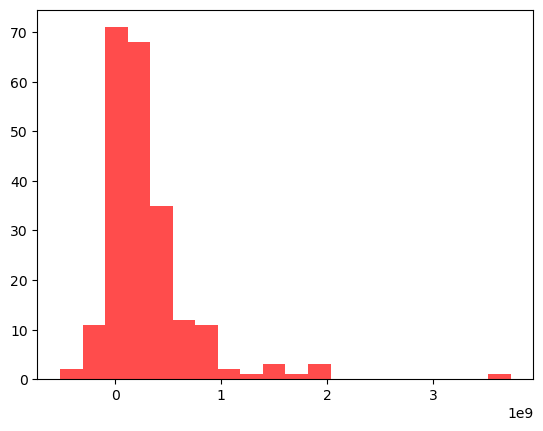

In [230]:
# Sort producers by total profit (total gross)
sorted_producers = producers_df.sort_values(by='Tot_Profit', ascending=False)
print(sorted_producers.head())
plt.hist(producers_df['Tot_Profit'], bins=20, alpha=0.7, label='RT Score', color='red')

                        Movie Count    Tot_Profit  Average_Profit  \
Christopher Meledandri            9  1.922116e+09    2.135684e+08   
Janet Healy                       9  1.922116e+09    2.135684e+08   
James Cameron                     7  1.284845e+09    1.835493e+08   
Kevin Feige                      24  3.737011e+09    1.557088e+08   
Patrick Crowley                   7  8.953572e+08    1.279082e+08   
...                             ...           ...             ...   
Mary Parent                      12 -2.739186e+08   -2.739186e+07   
Alex Garcia                       6 -1.478055e+08   -3.695137e+07   
Thomas Tull                      11 -4.957508e+08   -4.506825e+07   
Jon Jashni                       10 -5.229579e+08   -4.754163e+07   
Dana Goldberg                     8 -2.687581e+08   -6.718952e+07   

                         Max_Profit   Min_Profit  
Christopher Meledandri  293384330.0   77790990.0  
Janet Healy             293384330.0   77790990.0  
James Cameron     

(array([ 1.,  2.,  3., 10., 31., 43., 44., 30., 21., 15.,  7.,  2.,  6.,
         2.,  0.,  1.,  0.,  1.,  0.,  2.]),
 array([-6.71895230e+07, -5.31516252e+07, -3.91137274e+07, -2.50758296e+07,
        -1.10379318e+07,  2.99996594e+06,  1.70378637e+07,  3.10757615e+07,
         4.51136593e+07,  5.91515571e+07,  7.31894549e+07,  8.72273527e+07,
         1.01265250e+08,  1.15303148e+08,  1.29341046e+08,  1.43378944e+08,
         1.57416842e+08,  1.71454739e+08,  1.85492637e+08,  1.99530535e+08,
         2.13568433e+08]),
 <BarContainer object of 20 artists>)

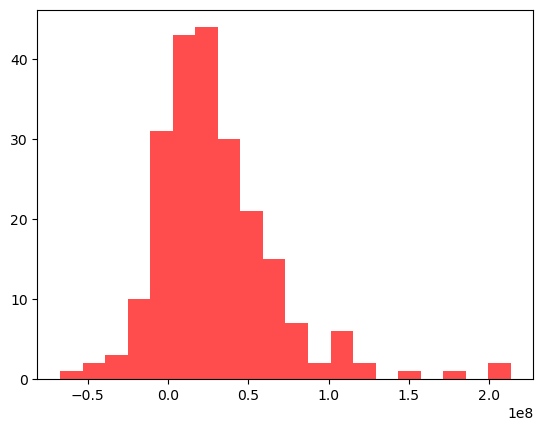

In [221]:
# Sort producers by total profit (total gross)
sorted_producers = producers_df.sort_values(by='Average_Profit', ascending=False)
print(sorted_producers)
plt.hist(producers_df['Average_Profit'], bins=20, alpha=0.7, label='RT Score', color='red')

                   Movie Count    Tot_Profit  Average_Profit   Max_Profit  \
David Ellison               10  1.572278e+08    2.620463e+07  548732821.0   
Jerry Bruckheimer           26  1.604152e+09    6.416607e+07  548732821.0   
James Cameron                7  1.284845e+09    1.835493e+08  548221649.0   
Frank Marshall              15  1.611868e+09    1.074579e+08  503406625.0   
Patrick Crowley              7  8.953572e+08    1.279082e+08  503406625.0   
...                        ...           ...             ...          ...   
Jeremy Bolt                 12 -1.901425e+08   -1.901425e+07    7119709.0   
Don Carmody                  8 -1.249566e+08   -2.082611e+07    6201453.0   
Robert Kulzer               11 -1.874687e+08   -2.343359e+07    5648679.0   
Steve Chasman                6 -5.076782e+07   -1.269195e+07    1715062.0   
Dana Goldberg                8 -2.687581e+08   -6.718952e+07  -27765978.0   

                    Min_Profit  
David Ellison     -122746923.0  
Jerry Bru

(array([ 1., 23., 30., 22., 32., 37., 23., 12.,  2., 10.,  7., 10.,  1.,
         3.,  0.,  2.,  0.,  0.,  3.,  3.]),
 array([-2.77659780e+07,  1.05896195e+06,  2.98839019e+07,  5.87088418e+07,
         8.75337818e+07,  1.16358722e+08,  1.45183662e+08,  1.74008602e+08,
         2.02833542e+08,  2.31658482e+08,  2.60483422e+08,  2.89308361e+08,
         3.18133301e+08,  3.46958241e+08,  3.75783181e+08,  4.04608121e+08,
         4.33433061e+08,  4.62258001e+08,  4.91082941e+08,  5.19907881e+08,
         5.48732821e+08]),
 <BarContainer object of 20 artists>)

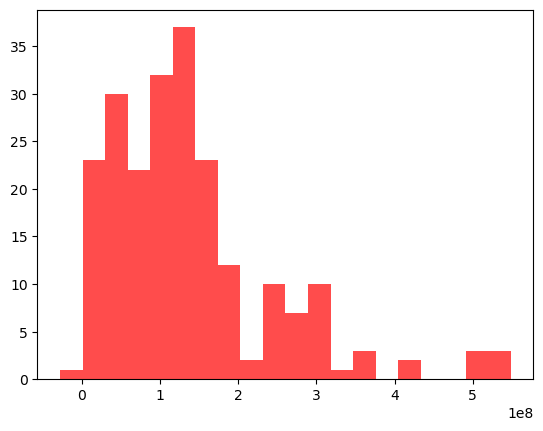

In [222]:
# Sort producers by total profit (total gross)
sorted_producers = producers_df.sort_values(by='Max_Profit', ascending=False)
print(sorted_producers)
plt.hist(producers_df['Max_Profit'], bins=20, alpha=0.7, label='RT Score', color='red')

                        Movie Count    Tot_Profit  Average_Profit  \
Janet Healy                       9  1.922116e+09    2.135684e+08   
Christopher Meledandri            9  1.922116e+09    2.135684e+08   
Oren Peli                         6  4.619997e+08    7.699995e+07   
Oren Koules                       7  2.362372e+08    4.724744e+07   
Mark Burg                         6  1.902904e+08    4.757261e+07   
...                             ...           ...             ...   
Christopher Nolan                 8  7.130343e+08    1.018620e+08   
Emma Thomas                       9  7.698978e+08    9.623722e+07   
Charles Roven                    17  7.902943e+08    5.644959e+07   
Deborah Snyder                    9  1.855343e+08    2.650490e+07   
Colin Wilson                     10 -8.855746e+07   -8.855746e+06   

                         Max_Profit   Min_Profit  
Janet Healy             293384330.0   77790990.0  
Christopher Meledandri  293384330.0   77790990.0  
Oren Peli         

(array([ 1.,  2.,  3.,  8.,  4.,  4., 16., 23., 25., 13., 34., 21., 33.,
        21.,  8.,  2.,  0.,  1.,  0.,  2.]),
 array([-1.76921900e+08, -1.64186256e+08, -1.51450611e+08, -1.38714966e+08,
        -1.25979322e+08, -1.13243678e+08, -1.00508033e+08, -8.77723885e+07,
        -7.50367440e+07, -6.23010995e+07, -4.95654550e+07, -3.68298105e+07,
        -2.40941660e+07, -1.13585215e+07,  1.37712300e+06,  1.41127675e+07,
         2.68484120e+07,  3.95840565e+07,  5.23197010e+07,  6.50553455e+07,
         7.77909900e+07]),
 <BarContainer object of 20 artists>)

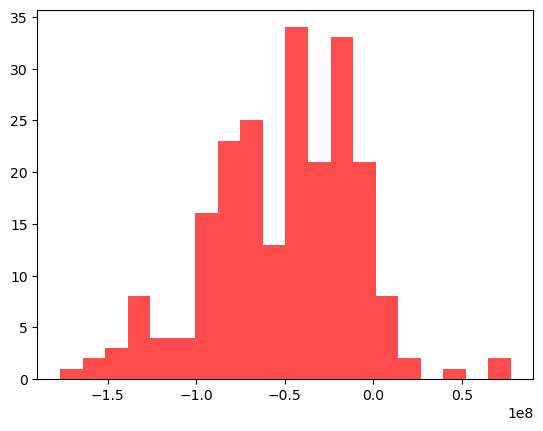

In [223]:
# Sort producers by total profit (total gross)
sorted_producers = producers_df.sort_values(by='Min_Profit', ascending=False)
print(sorted_producers)
plt.hist(producers_df['Min_Profit'], bins=20, alpha=0.7, label='RT Score', color='red')

In [237]:
producers_df.loc['James Cameron']

Movie Count      7.000000e+00
Tot_Profit       1.284845e+09
Avg_Profit       1.835493e+08
Max_Profit       5.482216e+08
Min_Profit      -1.227469e+08
Tot_Rev          2.643845e+09
Avg_Rev          3.776921e+08
Max_Rev          7.852216e+08
Min_Rev          6.225308e+07
Tot_Bugd         1.359000e+09
Avg_Budg         1.941429e+08
Max_Budg         3.500000e+08
Min_Budg         1.020000e+08
Avg_ROI          8.244335e-01
Max_ROI          2.371463e+00
Min_ROI         -6.634969e-01
Avg_RT_Ascore    8.057143e+00
Max_RT_Ascore    9.000000e+00
Min_RT_Ascore    6.600000e+00
Name: James Cameron, dtype: float64

In [238]:
producers_df.sort_values(by='Max_ROI', ascending=False)

,Movie Count,Tot_Profit,Avg_Profit,Max_Profit,Min_Profit,Tot_Rev,Avg_Rev,Max_Rev,Min_Rev,Tot_Bugd,Avg_Budg,Max_Budg,Min_Budg,Avg_ROI,Max_ROI,Min_ROI,Avg_RT_Ascore,Max_RT_Ascore,Min_RT_Ascore
Jason Blum,26,1.910995e+09,6.164502e+07,171696665.0,-1456527.0,2.410110e+09,7.774550e+07,176196665.0,11977130.0,499115000.0,1.610048e+07,62000000.0,15000.0,241.151251,7193.587333,-0.036413,7.150000,9.0,5.6
Oren Peli,6,4.619997e+08,7.699995e+07,107903810.0,42218558.0,4.865147e+08,8.108578e+07,107918810.0,52218558.0,24515000.0,4.085833e+06,10000000.0,15000.0,1215.931551,7193.587333,4.221856,6.700000,7.2,6.4
Gary Goetzman,10,3.590999e+08,3.989999e+07,236438208.0,-25331675.0,9.370999e+08,1.041222e+08,241438208.0,12668325.0,578000000.0,6.422222e+07,165000000.0,5000000.0,5.470656,47.287642,-0.666623,7.260000,9.0,4.6
Tom Hanks,6,3.877613e+08,6.462688e+07,236438208.0,-22766533.0,8.727613e+08,1.454602e+08,241438208.0,64267657.0,485000000.0,8.083333e+07,165000000.0,5000000.0,8.163119,47.287642,-0.227665,7.633333,9.0,6.6
Ivan Reitman,6,2.971013e+08,4.951689e+07,138600000.0,-10939814.0,5.741013e+08,9.568355e+07,141600000.0,58060186.0,277000000.0,4.616667e+07,80000000.0,3000000.0,8.513020,46.200000,-0.158548,7.666667,8.8,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samuel Hadida,8,-4.897366e+07,-6.121707e+06,7119709.0,-22654469.0,2.870263e+08,3.587829e+07,60128566.0,7689607.0,336000000.0,4.200000e+07,65000000.0,13000000.0,-0.149207,0.215749,-0.743680,7.000000,8.8,6.4
Jeremy Bolt,12,-1.901425e+08,-1.901425e+07,7119709.0,-76780252.0,3.778575e+08,3.778575e+07,60128566.0,20374484.0,568000000.0,5.680000e+07,100000000.0,33000000.0,-0.244112,0.215749,-0.767803,6.650000,7.6,5.6
Don Carmody,8,-1.249566e+08,-2.082611e+07,6201453.0,-76780252.0,2.550434e+08,4.250723e+07,60128566.0,23219748.0,380000000.0,6.333333e+07,100000000.0,45000000.0,-0.252884,0.137810,-0.767803,6.775000,7.4,5.6
Steve Chasman,6,-5.076782e+07,-1.269195e+07,1715062.0,-44875034.0,1.232322e+08,3.080805e+07,43905746.0,22486409.0,174000000.0,4.350000e+07,70000000.0,25000000.0,-0.197103,0.057169,-0.641072,6.400000,6.8,6.0


In [240]:
#Run at the end
df_movie.to_csv('producers_df.csv', index=False)